# 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

In [2]:
import cellpose
from cellpose import models

In [3]:
from tqdm import tqdm

# 2. Define data parameters

In [5]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 3

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"other":3}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
other_key="other"

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:False}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done


############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################

############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
data_output_folder = r"D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220609IF_220302exp_p53ko_fixed_40x\220302_p53ko_8days"
data_main_folder =os.path.join(data_output_folder, '*')
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_input_folder = data_main_folder
data_files = [file for file in glob.glob(data_input_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_220302exp_p53ko_fixed_40x\\220302_p53ko_8days\\220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-561_002.nd2']

In [6]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
_analyze_all_nd = True
#_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    #fov_to_exclude_dict = {1:[4,5],5:[2,3]}
    fov_to_exclude_dict = {1:[16]}
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
# use 200 for 40x images
small_53BP_size = 200

# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 1000

# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be good since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
if not use_dna_nuclei:
    dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [0,2048]  # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = True



# 3. Analyze data

In [7]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()


# Initiate cellpose model
model= models.Cellpose(gpu=False, model_type='nuclei',)
####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]

    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
                    
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
            
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in tqdm(fov_of_interest[:]):                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei signal to do segmenation by cellpose
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[dna_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                #
                nuclei_mask_3d,flows, styles, diams = model.eval(image_cell_3d, diameter=90, 
                                                    channels = [0,0],
                                                   flow_threshold=1, do_3D=False)
                
                noncell_mask_all = nuclei_mask_3d==0
                
                # remove edge cell
                nuclei_mask_3d=cellpose.utils.remove_edge_masks(nuclei_mask_3d, change_index=True)
                nuclei_mask_3d=cellpose.utils.fill_holes_and_remove_small_masks(nuclei_mask_3d, min_size=nuclei_filter)
                
                mask_save_path = data_output_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                if not os.path.exists(mask_save_path):
                    os.makedirs(mask_save_path)
                mask_name = f'Nuclei_segmenations_exclude_edges_Pos_{_fov_id+1}.tif'
                if os.path.exists(mask_save_path+os.sep+mask_name):
                    os.remove(mask_save_path+os.sep+mask_name)
                io.imsave(mask_save_path+os.sep+mask_name,(skimage.img_as_ubyte(nuclei_mask_3d)), check_contrast=False)
                
                #print(num_of_nuclei)
                # if use the cell coord refined analysis
                cell_coord_list  = []
                for i in np.unique(nuclei_mask_3d)[:]:
                    if i >0:
                        # initate dict to store result
                        measurement_each_dict = {}
                        _cell_id=i
                        cand_nucleus = nuclei_mask_3d == i
                        cand_nucleus[cand_nucleus>0]=1
                        cand_nucleus = np.array(cand_nucleus)
                        # append the coord for the objects of interest
                        region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                        # centroid coord as YX, select the cells within the predefined bound
                        check_Y_pos = region.centroid[0] >= search_xylim[0] and region.centroid[0] <= search_xylim[1]
                        check_X_pos = region.centroid[1] >= search_xylim[0] and region.centroid[1] <= search_xylim[1]
                        if check_Y_pos and check_X_pos:
                            cell_center = [int(region.centroid[1]),int(region.centroid[0])]
                            cell_coord_list.append(cell_center)
                            if _verbose:
                                print (f'-- Processing Cell#{_cell_id} from the image')

                            # define as nuclei mask
                            nuclei_to_measure = cand_nucleus
                            noncell_background = noncell_mask_all

                            # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                            #image_fl = []
                            image_std = []
                            image_3d_for_label = []

                            for _lyr in range(num_of_planes): # ch index starts from 0
                                image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                                # do cropping if necessary; remember to inver XY
                                if crop_image: # current crop size as rough cell size
                                    crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                                    crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                                    crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                                    crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                                    image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]


                                 # use image signal STD distribution to find the best focal plane for the plane of interest
                                _fl=image_array_fl.flatten()
                                image_std.append(np.std(_fl))
                                #also append the image for later potential usage (eg. re-adjust focal plane)
                                #image_3d_for_label.append(image_array_fl)

                            # find the initial best focal plane using std features          
                            best_plane_index = np.argmax(np.array(image_std))
                            if _verbose:
                                print(f"-- Analyzing the plane {best_plane_index+1} in fov {_fov_id+1}.")
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=best_plane_index))                  

                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                nuclei_to_measure = nuclei_to_measure[crop_y1:crop_y2,crop_x1:crop_x2]
                                noncell_background = noncell_background[crop_y1:crop_y2,crop_x1:crop_x2]


                            # Get cellular mdc mask 
                            mdc_intensity = sel_img*nuclei_to_measure
                            mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                            mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                            mdc_mask = np.logical_and(sel_img>mdc_positive_th, nuclei_to_measure)
                            mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                            mdc_chr_mask = ndi.binary_fill_holes(mdc_chr_mask)
                            mdc_chr_mask = dilation(mdc_chr_mask,disk(1))
                            mdc_chr_mask = erosion(mdc_chr_mask,disk(1))

                            # Append info and results for cells of interest
                            measurement_each_dict['exp_name']=data_input_folder.split('\\')[-2]
                            measurement_each_dict['position_id']=f'{data_name}_Pos{_fov_id+1}'
                            measurement_each_dict['cell_id']=int(_cell_id+1)
                            measurement_each_dict['cell_xyz_coord']=[cell_center, best_plane_index+1]

                            measurement_each_dict['mdc1_size']=np.sum(mdc_chr_mask)
                            measurement_each_dict['nucleus_size']=np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_relative_size']=np.sum(mdc_chr_mask)/np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_mdc1_intensity']=np.mean((sel_img * mdc_chr_mask)[mdc_chr_mask!=0])
                            measurement_each_dict['nucleus_mdc1_intensity']=np.mean((sel_img * nuclei_to_measure)[nuclei_to_measure!=0])
                            measurement_each_dict['noncell_mdc1_intensity']=np.mean((sel_img * noncell_background)[noncell_background!=0])
                            measurement_each_dict['mdc1_mdc1_norm_intensity']=((measurement_each_dict['mdc1_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity'])
                                                                               /(measurement_each_dict['nucleus_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity']))


                            measurement_for_each_cell_df=pd.DataFrame.from_dict(measurement_each_dict,orient='index').transpose()
                            measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])

                            # Save individual valid mask or image for each cell 
                            mask_file_list = [mdc_chr_mask,nuclei_to_measure,sel_img]
                            mask_savename_list = [f'cell_{_cell_id+1}_cand_MN_body.tif',
                                                  f'cell_{_cell_id+1}_nucleus.tif',
                                                  f'cell_{_cell_id+1}_MDC1_image.tif',]

                            for _name, _file in zip(mask_savename_list,mask_file_list):
                                # remove old ones if exist
                                if os.path.exists(mask_save_path+os.sep+_name):
                                    os.remove(mask_save_path+os.sep+_name)
                                if _name == f'cell_{_cell_id+1}_MDC1_image.tif':
                                    if save_crop_raw_image:
                                        io.imsave(mask_save_path+os.sep+_name,_file, check_contrast=False)
                                    else:
                                        pass
                                else:
                                    io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)



                                
# Save excel result
_save_results = True

if _save_results:
    analysis_savename = f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_output_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
                            
                        

  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 14 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#2 from the image


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 2 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 1.
-- Processing Cell#14 from the image


  1%|▉                                                                                  | 1/90 [00:39<59:14, 39.94s/it]

-- Analyzing the plane 1 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 17 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 2.
-

  2%|█▊                                                                               | 2/90 [01:24<1:02:21, 42.51s/it]

-- Analyzing the plane 1 in fov 2.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 31 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 3.
-

  3%|██▋                                                                              | 3/90 [02:22<1:11:52, 49.57s/it]

-- Analyzing the plane 1 in fov 3.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 8 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 4.
-- Processing Cell#8 from the image


  4%|███▌                                                                             | 4/90 [02:57<1:02:42, 43.75s/it]

-- Analyzing the plane 1 in fov 4.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 4 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 5.
-- Processing Cell#4 from the image


  6%|████▌                                                                              | 5/90 [03:27<55:06, 38.90s/it]

-- Analyzing the plane 1 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 19 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 6.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 6.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 6.
-

  7%|█████▌                                                                             | 6/90 [04:15<58:45, 41.97s/it]

-- Analyzing the plane 1 in fov 6.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#13 from the image
-- Analyzing the plane 

  8%|██████▍                                                                            | 7/90 [04:57<58:20, 42.17s/it]

-- Analyzing the plane 1 in fov 7.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 30 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 8.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 8.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 8.
-

  9%|███████▏                                                                         | 8/90 [05:56<1:04:52, 47.47s/it]

-- Analyzing the plane 1 in fov 8.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 5 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#5 from the image


 10%|████████▎                                                                          | 9/90 [06:28<57:22, 42.51s/it]

-- Analyzing the plane 2 in fov 9.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 13 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 10.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 10.


 11%|█████████                                                                         | 10/90 [07:07<55:12, 41.41s/it]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 16 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 11.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 12%|██████████                                                                        | 11/90 [07:50<55:20, 42.04s/it]

-- Analyzing the plane 1 in fov 11.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 12.
-- Processing Cell#13 from the image
-- Analyzi

 13%|██████████▉                                                                       | 12/90 [08:37<56:21, 43.35s/it]

-- Analyzing the plane 1 in fov 12.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 12 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#12 from the image


 14%|███████████▊                                                                      | 13/90 [09:16<54:04, 42.13s/it]

-- Analyzing the plane 1 in fov 13.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 14.
-- Processing Cell#13 from the image


 16%|████████████▊                                                                     | 14/90 [09:54<51:49, 40.91s/it]

-- Analyzing the plane 2 in fov 14.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 15.
-- Processing Cell#13 from the image


 17%|█████████████▋                                                                    | 15/90 [10:34<50:46, 40.62s/it]

-- Analyzing the plane 1 in fov 15.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 15 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 16.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 18%|██████████████▌                                                                   | 16/90 [11:17<51:04, 41.41s/it]

-- Analyzing the plane 1 in fov 16.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 11 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 17.
-- Processing Cell#11 from the image


 19%|███████████████▍                                                                  | 17/90 [11:55<49:09, 40.40s/it]

-- Analyzing the plane 1 in fov 17.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 18.
-- Processing Cell#13 from the image
-- Analyzi

 20%|████████████████▍                                                                 | 18/90 [12:39<49:31, 41.28s/it]

-- Analyzing the plane 1 in fov 18.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#13 from the image
-- Analyzi

 21%|█████████████████▎                                                                | 19/90 [13:25<50:45, 42.90s/it]

-- Analyzing the plane 2 in fov 19.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 20.


 22%|██████████████████▏                                                               | 20/90 [14:01<47:30, 40.73s/it]

-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 21.
-- Processing Cell#8 from the image


 23%|███████████████████▏                                                              | 21/90 [14:37<45:15, 39.35s/it]

-- Analyzing the plane 1 in fov 21.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#13 from the image
-- Analyzi

 24%|████████████████████                                                              | 22/90 [15:25<47:29, 41.90s/it]

-- Analyzing the plane 1 in fov 22.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 23.
-- Processing Cell#13 from the image
-- Analyzi

 26%|████████████████████▉                                                             | 23/90 [16:06<46:38, 41.77s/it]

-- Analyzing the plane 1 in fov 23.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 18 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 27%|█████████████████████▊                                                            | 24/90 [16:51<46:54, 42.64s/it]

-- Analyzing the plane 2 in fov 24.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#5 from the image


 28%|██████████████████████▊                                                           | 25/90 [17:21<42:14, 38.99s/it]

-- Analyzing the plane 2 in fov 25.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 20 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 29%|███████████████████████▋                                                          | 26/90 [18:09<44:17, 41.52s/it]

-- Analyzing the plane 2 in fov 26.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 23 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 30%|████████████████████████▌                                                         | 27/90 [18:59<46:20, 44.13s/it]

-- Analyzing the plane 1 in fov 27.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#13 from the image
-- Analyzi

 31%|█████████████████████████▌                                                        | 28/90 [19:43<45:27, 43.99s/it]

-- Analyzing the plane 1 in fov 28.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#13 from the image
-- Analyzi

 32%|██████████████████████████▍                                                       | 29/90 [20:33<46:42, 45.95s/it]

-- Analyzing the plane 1 in fov 29.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#13 from the image
-- Analyzi

 33%|███████████████████████████▎                                                      | 30/90 [21:17<45:21, 45.37s/it]

-- Analyzing the plane 1 in fov 30.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#13 from the image
-- Analyzi

 34%|████████████████████████████▏                                                     | 31/90 [22:04<45:06, 45.87s/it]

-- Analyzing the plane 2 in fov 31.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#13 from the image
-- Analyzi

 36%|█████████████████████████████▏                                                    | 32/90 [23:02<47:53, 49.55s/it]

-- Analyzing the plane 1 in fov 32.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#12 from the image


 37%|██████████████████████████████                                                    | 33/90 [23:42<44:17, 46.62s/it]

-- Analyzing the plane 2 in fov 33.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 24 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 34.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 34.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 38%|██████████████████████████████▉                                                   | 34/90 [24:36<45:23, 48.64s/it]

-- Analyzing the plane 1 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#13 from the image
-- Analyzi

 39%|███████████████████████████████▉                                                  | 35/90 [25:22<44:00, 48.01s/it]

-- Analyzing the plane 2 in fov 35.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#13 from the image
-- Analyzi

 40%|████████████████████████████████▊                                                 | 36/90 [26:15<44:24, 49.34s/it]

-- Analyzing the plane 1 in fov 36.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 37.
-- Processing Cell#13 from the image
-- Analyzi

 41%|█████████████████████████████████▋                                                | 37/90 [26:59<42:12, 47.77s/it]

-- Analyzing the plane 1 in fov 37.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 38.
-- Processing Cell#12 from the image


 42%|██████████████████████████████████▌                                               | 38/90 [27:39<39:25, 45.49s/it]

-- Analyzing the plane 1 in fov 38.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 10 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 39.
-- Processing Cell#10 from the image


 43%|███████████████████████████████████▌                                              | 39/90 [28:15<36:15, 42.66s/it]

-- Analyzing the plane 1 in fov 39.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 40.
-- Processing Cell#13 from the image
-- Analyzi

 44%|████████████████████████████████████▍                                             | 40/90 [29:06<37:34, 45.08s/it]

-- Analyzing the plane 1 in fov 40.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 41.
-- Processing Cell#13 from the image


 46%|█████████████████████████████████████▎                                            | 41/90 [29:45<35:24, 43.36s/it]

-- Analyzing the plane 3 in fov 41.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#13 from the image
-- Analyzi

 47%|██████████████████████████████████████▎                                           | 42/90 [30:27<34:16, 42.85s/it]

-- Analyzing the plane 1 in fov 42.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 7 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#7 from the image


 48%|███████████████████████████████████████▏                                          | 43/90 [31:00<31:13, 39.87s/it]

-- Analyzing the plane 2 in fov 43.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
 49%|████████████████████████████████████████                                          | 44/90 [31:27<27:41, 36.11s/it]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 6 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#6 from the image


 50%|█████████████████████████████████████████                                         | 45/90 [31:59<26:06, 34.81s/it]

-- Analyzing the plane 2 in fov 45.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image


 51%|█████████████████████████████████████████▉                                        | 46/90 [32:27<24:01, 32.77s/it]

-- Analyzing the plane 2 in fov 46.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 47.
-- Processing Cell#13 from the image


 52%|██████████████████████████████████████████▊                                       | 47/90 [33:06<24:52, 34.70s/it]

-- Analyzing the plane 2 in fov 47.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 48.
-- Processing Cell#13 from the image
-- Analyzi

 53%|███████████████████████████████████████████▋                                      | 48/90 [33:47<25:35, 36.56s/it]

-- Analyzing the plane 2 in fov 48.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#13 from the image
-- Analyzi

 54%|████████████████████████████████████████████▋                                     | 49/90 [34:31<26:38, 38.98s/it]

-- Analyzing the plane 2 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

 56%|█████████████████████████████████████████████▌                                    | 50/90 [35:20<27:48, 41.72s/it]

-- Analyzing the plane 1 in fov 50.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 9 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 51.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 51.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 51.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 51.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 51.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 51.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 51.
-- Processing Cell#9 from the image


 57%|██████████████████████████████████████████████▍                                   | 51/90 [35:55<25:57, 39.95s/it]

-- Analyzing the plane 2 in fov 51.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 52.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 52.
-- Processing Cell#12 from the image


 58%|███████████████████████████████████████████████▍                                  | 52/90 [36:34<25:06, 39.66s/it]

-- Analyzing the plane 2 in fov 52.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 53.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 53.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 53.
-- Processing Cell#13 from the image
-- Analyzi

 59%|████████████████████████████████████████████████▎                                 | 53/90 [37:20<25:35, 41.50s/it]

-- Analyzing the plane 1 in fov 53.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 3 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 54.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 54.
-- Processing Cell#3 from the image


 60%|█████████████████████████████████████████████████▏                                | 54/90 [37:50<22:44, 37.90s/it]

-- Analyzing the plane 4 in fov 54.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 55.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 55.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 55.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 55.
-- Processing Cell#13 from the image
-- Analyzi

 61%|██████████████████████████████████████████████████                                | 55/90 [38:42<24:42, 42.37s/it]

-- Analyzing the plane 2 in fov 55.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 21 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 56.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 56.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 56.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 56.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 56.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 62%|███████████████████████████████████████████████████                               | 56/90 [39:30<24:55, 43.98s/it]

-- Analyzing the plane 3 in fov 56.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 57.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 57.
-- Processing Cell#13 from the image
-- Analyzi

 63%|███████████████████████████████████████████████████▉                              | 57/90 [40:13<23:58, 43.58s/it]

-- Analyzing the plane 3 in fov 57.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 29 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 58.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 64%|████████████████████████████████████████████████████▊                             | 58/90 [41:10<25:27, 47.73s/it]

-- Analyzing the plane 4 in fov 58.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 59.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 59.
-- Processing Cell#10 from the image


 66%|█████████████████████████████████████████████████████▊                            | 59/90 [41:48<23:08, 44.78s/it]

-- Analyzing the plane 3 in fov 59.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 26 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 60.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 60.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 67%|██████████████████████████████████████████████████████▋                           | 60/90 [42:43<23:55, 47.84s/it]

-- Analyzing the plane 3 in fov 60.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 61.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 61.
-- Processing Cell#13 from the image
-- Analyzi

 68%|███████████████████████████████████████████████████████▌                          | 61/90 [43:32<23:15, 48.11s/it]

-- Analyzing the plane 3 in fov 61.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 62.
-- Processing Cell#13 from the image
-- Analyzi

 69%|████████████████████████████████████████████████████████▍                         | 62/90 [44:17<22:03, 47.28s/it]

-- Analyzing the plane 1 in fov 62.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 63.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 63.
-- Processing Cell#13 from the image
-- Analyzi

 70%|█████████████████████████████████████████████████████████▍                        | 63/90 [44:56<20:10, 44.82s/it]

-- Analyzing the plane 3 in fov 63.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 27 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 64.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 64.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 71%|██████████████████████████████████████████████████████████▎                       | 64/90 [45:49<20:24, 47.11s/it]

-- Analyzing the plane 2 in fov 64.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 65.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 65.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 65.
-- Processing Cell#13 from the image
-- Analyzi

 72%|███████████████████████████████████████████████████████████▏                      | 65/90 [46:26<18:25, 44.22s/it]

-- Analyzing the plane 3 in fov 65.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 66.
-- Processing Cell#12 from the image


 73%|████████████████████████████████████████████████████████████▏                     | 66/90 [47:03<16:47, 41.97s/it]

-- Analyzing the plane 3 in fov 66.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 67.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 67.
-- Processing Cell#10 from the image


 74%|█████████████████████████████████████████████████████████████                     | 67/90 [47:37<15:11, 39.62s/it]

-- Analyzing the plane 3 in fov 67.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 68.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 68.
-- Processing Cell#11 from the image


 76%|█████████████████████████████████████████████████████████████▉                    | 68/90 [48:10<13:47, 37.59s/it]

-- Analyzing the plane 1 in fov 68.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 25 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 69.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 77%|██████████████████████████████████████████████████████████████▊                   | 69/90 [48:59<14:20, 41.00s/it]

-- Analyzing the plane 2 in fov 69.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 70.
-- Processing Cell#13 from the image
-- Analyzi

 78%|███████████████████████████████████████████████████████████████▊                  | 70/90 [49:40<13:38, 40.91s/it]

-- Analyzing the plane 1 in fov 70.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 71.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 71.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 71.
-- Processing Cell#13 from the image
-- Analyzi

 79%|████████████████████████████████████████████████████████████████▋                 | 71/90 [50:20<12:54, 40.75s/it]

-- Analyzing the plane 4 in fov 71.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 72.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 72.
-- Processing Cell#13 from the image
-- Analyzi

 80%|█████████████████████████████████████████████████████████████████▌                | 72/90 [51:01<12:15, 40.84s/it]

-- Analyzing the plane 2 in fov 72.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 73.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 73.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 73.
-- Processing Cell#13 from the image
-- Analyzi

 81%|██████████████████████████████████████████████████████████████████▌               | 73/90 [51:40<11:23, 40.19s/it]

-- Analyzing the plane 3 in fov 73.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 22 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 74.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 82%|███████████████████████████████████████████████████████████████████▍              | 74/90 [52:23<10:57, 41.10s/it]

-- Analyzing the plane 5 in fov 74.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 75.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 75.
-- Processing Cell#13 from the image
-- Analyzi

 83%|████████████████████████████████████████████████████████████████████▎             | 75/90 [53:03<10:10, 40.69s/it]

-- Analyzing the plane 3 in fov 75.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 76.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 76.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 76.
-- Processing Cell#13 from the image
-- Analyzi

 84%|█████████████████████████████████████████████████████████████████████▏            | 76/90 [53:49<09:53, 42.42s/it]

-- Analyzing the plane 3 in fov 76.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 77.
-- Processing Cell#13 from the image
-- Analyzi

 86%|██████████████████████████████████████████████████████████████████████▏           | 77/90 [54:33<09:15, 42.76s/it]

-- Analyzing the plane 3 in fov 77.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 78.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 78.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 78.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 78.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 78.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 78.
-- Processing Cell#13 from the image
-- Analyzi

 87%|███████████████████████████████████████████████████████████████████████           | 78/90 [55:16<08:34, 42.91s/it]

-- Analyzing the plane 3 in fov 78.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 79.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 79.
-- Processing Cell#13 from the image
-- Analyzi

 88%|███████████████████████████████████████████████████████████████████████▉          | 79/90 [56:00<07:55, 43.25s/it]

-- Analyzing the plane 3 in fov 79.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 80.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 80.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 80.
-- Processing Cell#13 from the image
-- Analyzi

 89%|████████████████████████████████████████████████████████████████████████▉         | 80/90 [56:46<07:19, 43.96s/it]

-- Analyzing the plane 1 in fov 80.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 81.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 81.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 81.
-- Processing Cell#13 from the image
-- Analyzi

 90%|█████████████████████████████████████████████████████████████████████████▊        | 81/90 [57:21<06:11, 41.27s/it]

-- Analyzing the plane 2 in fov 81.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 28 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 82.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 82.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 91%|██████████████████████████████████████████████████████████████████████████▋       | 82/90 [58:09<05:48, 43.55s/it]

-- Analyzing the plane 4 in fov 82.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 83.
-- Processing Cell#13 from the image
-- Analyzi

 92%|███████████████████████████████████████████████████████████████████████████▌      | 83/90 [58:47<04:52, 41.76s/it]

-- Analyzing the plane 3 in fov 83.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 84.
-- Processing Cell#13 from the image
-- Analyzi

 93%|████████████████████████████████████████████████████████████████████████████▌     | 84/90 [59:26<04:06, 41.07s/it]

-- Analyzing the plane 3 in fov 84.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 85.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 85.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 85.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 85.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 85.


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 85/90 [59:57<03:10, 38.01s/it]

-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 86.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 86.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 86.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 86.
-- Process

 96%|████████████████████████████████████████████████████████████████████████████▍   | 86/90 [1:00:33<02:29, 37.32s/it]

-- Analyzing the plane 3 in fov 86.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 87.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 87.
-- Processing Cell#13 from the image
-- Analyzi

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 87/90 [1:01:17<01:57, 39.24s/it]

-- Analyzing the plane 3 in fov 87.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 88.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 88.
-- Processing Cell#13 from the image
-- Analyzi

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 88/90 [1:01:50<01:14, 37.49s/it]

-- Analyzing the plane 4 in fov 88.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 89.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 89.
-- Processing Cell#13 from the image
-- Analyzi

 99%|███████████████████████████████████████████████████████████████████████████████ | 89/90 [1:02:25<00:36, 36.68s/it]

-- Analyzing the plane 3 in fov 89.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 90.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 90.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 90.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 90.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 90.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 90.
-- Processing Cell#10 from the image


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [1:02:55<00:00, 41.95s/it]

-- Analyzing the plane 3 in fov 90.


In [8]:
measurement_for_all_fov_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,2,"[[574, 612], 2]",0,1916,0.0,NaN,322.007307,134.707225,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,3,"[[529, 641], 2]",0,1048,0.0,NaN,263.262405,133.485269,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,4,"[[490, 683], 2]",0,1107,0.0,NaN,298.406504,130.96276,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,5,"[[740, 710], 2]",0,1398,0.0,NaN,290.766094,124.993013,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,6,"[[1367, 830], 1]",0,4231,0.0,NaN,333.59584,132.595019,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,7,"[[1283, 1412], 3]",0,4035,0.0,NaN,356.482032,124.805293,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,8,"[[1186, 1487], 3]",0,4801,0.0,NaN,327.223912,129.360733,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,9,"[[962, 1553], 3]",0,3734,0.0,NaN,553.83985,130.291647,NaN
0,220302_p53ko_8days,220302 RPE1 p53ko noco 8d aMDC1rb-488 H3K27ac-...,10,"[[1112, 1615], 3]",0,4529,0.0,NaN,358.827335,133.038879,NaN


In [9]:
import seaborn as sns

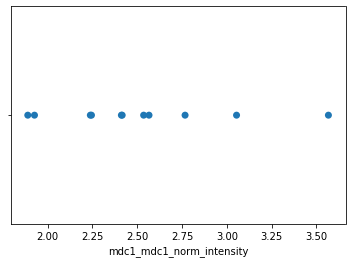

In [10]:
sns.swarmplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],s=7)

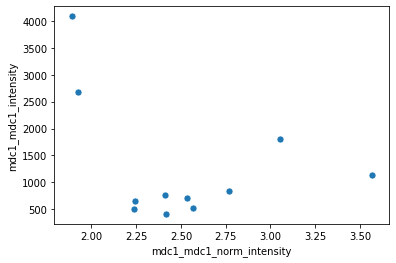

In [11]:
sns.scatterplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],measurement_for_all_fov_df['mdc1_mdc1_intensity'],s=50)

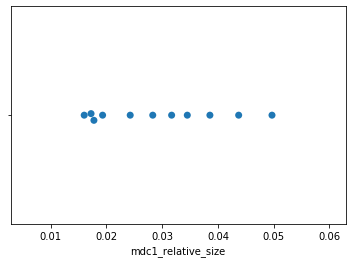

In [12]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_relative_size'],s=7)

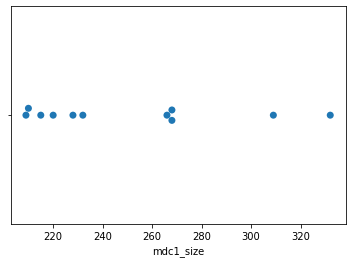

In [13]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_size'],s=7)

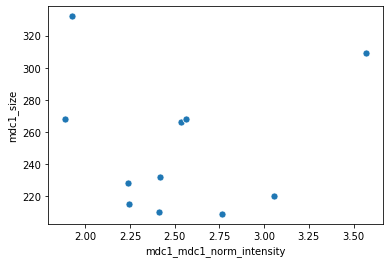

In [14]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_size'],s=50)

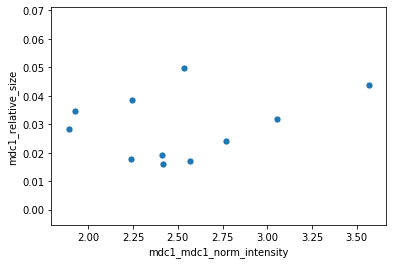

In [15]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_relative_size'],s=50)

In [16]:
measurement_for_all_fov_df_filter=measurement_for_all_fov_df[measurement_for_all_fov_df['nucleus_size']>2000]

In [17]:
len(measurement_for_all_fov_df_filter)

1325

In [18]:
len(measurement_for_all_fov_df)

1476

In [19]:
len(sel_mdc_df)

11

In [20]:
len(sel_mdc_df)/len(measurement_for_all_fov_df_filter)

0.00830188679245283

In [21]:
len(sel_mdc_df)/len(measurement_for_all_fov_df)

0.007452574525745257